# Check ToM ROIs
Natalia Vélez, February 2022

In [1]:
%matplotlib inline

import os, sys
import pandas as pd
import numpy as np
from nilearn import image,plotting,masking
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from os.path import join as opj

sys.path.append('..')
from utils import gsearch

sns.set_style('white')
sns.set_context('talk')

Make output directory:

In [2]:
out_dir = 'outputs/roi_picker'
os.makedirs(out_dir, exist_ok=True)

Find ROI files:

In [3]:
data_dir = '../../BIDS_data/derivatives/'
roi_dir = opj(data_dir, 'roi_picker')

roi_files = gsearch(roi_dir, '**', 'func', '*.nii.gz')
roi_files.sort()

print('Found %i ROI files' % len(roi_files))
print(*roi_files[:10], sep='\n')

Found 194 ROI files
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-DMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-LTPJ_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-MMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-PC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RSTS_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RTPJ_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-VMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-02/func/sub-02_task-tomloc_model-localizer_desc-DMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-02/func/sub-02_task-tomloc_model-localizer_desc-LTPJ_mask.nii.gz
../../

Find contrast images:

In [4]:
con_dir = opj(data_dir, 'glm')
con_files = gsearch(con_dir, 'sub-*', 'func', 'task-tomloc_model-localizer', 'con_0001.nii')
con_files.sort()

print('Found %i contrast files' % len(con_files))
print(*con_files[:10], sep='\n')

Found 28 contrast files
../../BIDS_data/derivatives/glm/sub-01/func/task-tomloc_model-localizer/con_0001.nii
../../BIDS_data/derivatives/glm/sub-02/func/task-tomloc_model-localizer/con_0001.nii
../../BIDS_data/derivatives/glm/sub-04/func/task-tomloc_model-localizer/con_0001.nii
../../BIDS_data/derivatives/glm/sub-05/func/task-tomloc_model-localizer/con_0001.nii
../../BIDS_data/derivatives/glm/sub-06/func/task-tomloc_model-localizer/con_0001.nii
../../BIDS_data/derivatives/glm/sub-07/func/task-tomloc_model-localizer/con_0001.nii
../../BIDS_data/derivatives/glm/sub-08/func/task-tomloc_model-localizer/con_0001.nii
../../BIDS_data/derivatives/glm/sub-09/func/task-tomloc_model-localizer/con_0001.nii
../../BIDS_data/derivatives/glm/sub-10/func/task-tomloc_model-localizer/con_0001.nii
../../BIDS_data/derivatives/glm/sub-11/func/task-tomloc_model-localizer/con_0001.nii


## Tally functional ROIs

Tally files

In [5]:
roi_df = pd.DataFrame({'path': roi_files})
roi_df['subject'] = roi_df.path.str.extract('(sub-[0-9]{2})')
roi_df['roi'] = roi_df.path.str.extract('(?<=desc-)([A-Z]+)')
roi_df.head()

,path,subject,roi
0,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,DMPFC
1,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,LTPJ
2,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,MMPFC
3,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,PC
4,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,RSTS


Did all participants run successfully?

In [6]:
roi_df['subject'].agg('nunique')

28

How many participants have each ROI?

In [7]:
roi_df.groupby('roi').agg({'subject': 'nunique'})

,subject
roi,
DMPFC,28
LTPJ,28
MMPFC,27
PC,28
RSTS,28
RTPJ,28
VMPFC,27


Who's missing ROIs?

In [8]:
roi_pivot = roi_df.groupby(['subject', 'roi']).size().unstack(fill_value=0).astype(bool)
roi_pivot[~roi_pivot.all(axis=1)]

roi,DMPFC,LTPJ,MMPFC,PC,RSTS,RTPJ,VMPFC
subject,,,,,,,
sub-11,True,True,False,True,True,True,False


## Check ROI location and extent

Plot locations and extent of each ROI:

/n/sw/eb/apps/centos7/Anaconda3/2020.11/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/sw/eb/apps/centos7/Anaconda3/2020.11/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/n/sw/eb/apps/centos7/Anaconda3/2020.11/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(m

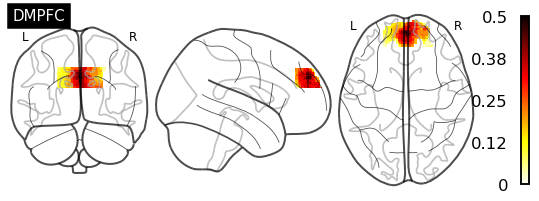

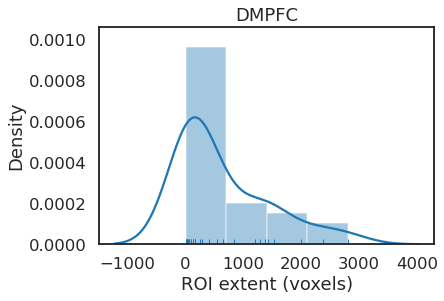

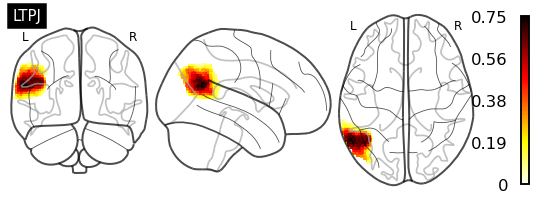

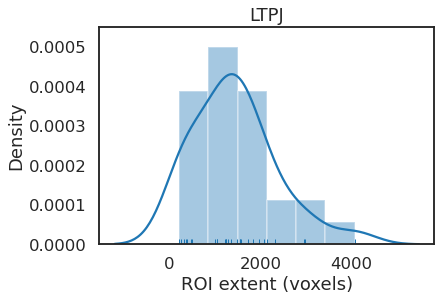

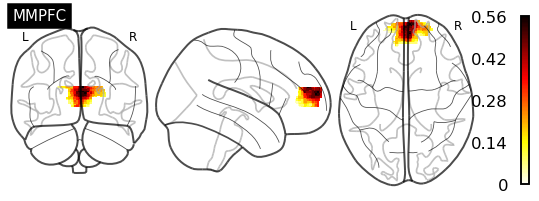

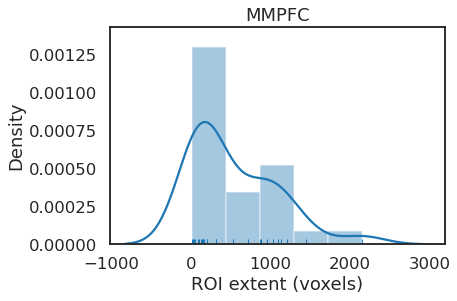

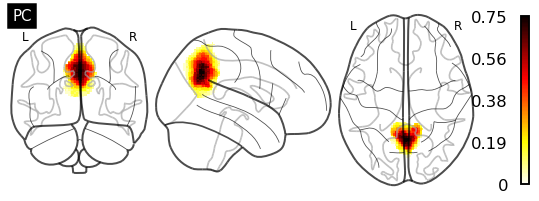

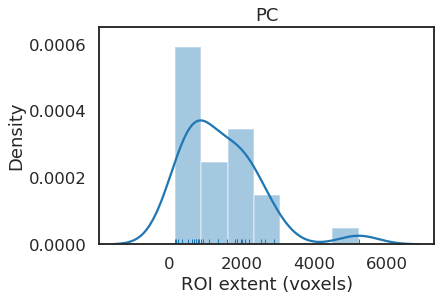

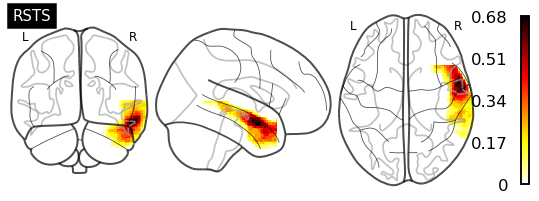

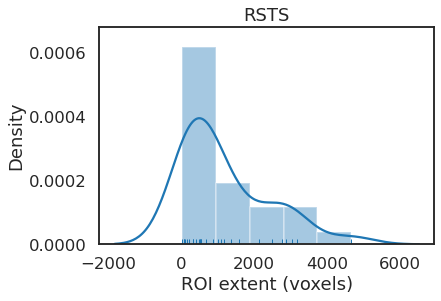

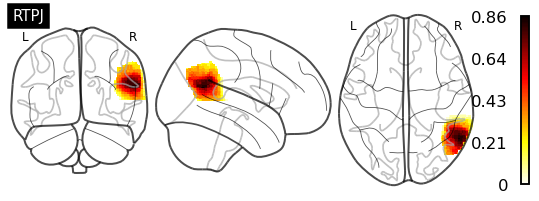

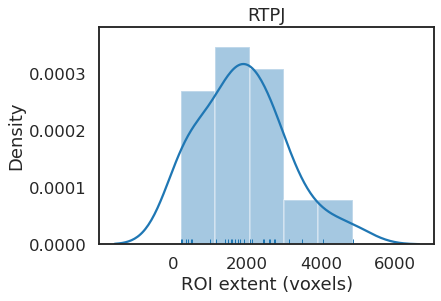

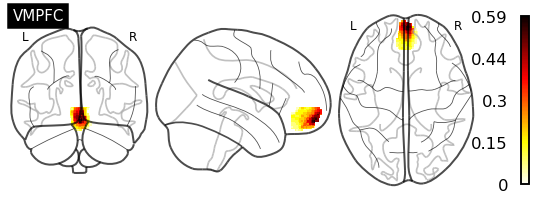

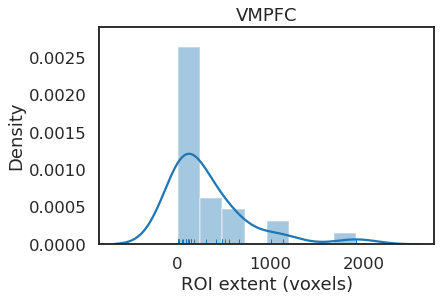

In [9]:
extent_list = []

for name, group in roi_df.groupby('roi'):
    # Load all ROI images
    roi_images = image.load_img(group.path.values.tolist())

    # Plot mean ROI
    mean_roi = image.mean_img(roi_images)
    mean_roi_plot = plotting.plot_glass_brain(mean_roi, colorbar=True, title=name)
    mean_roi_plot.savefig(opj(out_dir, '%s_location.png' % name))

    # Get ROI extent
    roi_extents = np.apply_over_axes(np.sum, roi_images.dataobj, range(roi_images.dataobj.ndim - 1)).flatten()
    roi_extents_df = group.copy()
    roi_extents_df['extent'] = roi_extents
    extent_list.append(roi_extents_df)

    fig,ax=plt.subplots()
    sns.distplot(roi_extents, rug=True, ax=ax)
    ax.set(title=name, xlabel='ROI extent (voxels)')
    plt.savefig(opj(out_dir, '%s_extent.png' % name), bbox_inches='tight')

Put together dataframe of ROI extents

In [10]:
all_roi_extents = pd.concat(extent_list)
all_roi_extents.to_csv(opj(out_dir, 'all_roi_extents.csv'), index=False)
all_roi_extents.groupby('roi').agg({'extent': ['count', 'min', 'max', 'mean']}).astype(int)

extent                 
       count  min   max  mean
roi                          
DMPFC     28   11  2815   652
LTPJ      28  215  4067  1436
MMPFC     27   16  2151   538
PC        28  172  5231  1442
RSTS      28   46  4667  1193
RTPJ      28  220  4858  1893
VMPFC     27   12  1914   333

Plot ROI locations/extents all together:

In [11]:
hypothesis_dir = '/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/fmriprep_space'

In [12]:
roi_masks = gsearch(hypothesis_dir, '*.nii.gz')
func_roi_masks = [r for r in roi_masks if 'ACC' not in r or 'bilateral' in r]
func_roi_masks.sort()

test_roi = image.load_img(func_roi_masks[0])
atlas_data = np.zeros(test_roi.shape + tuple([len(func_roi_masks)]))

for i,r in enumerate(func_roi_masks):
    mask = image.load_img(r)
    atlas_data[:,:,:,i] = mask.get_fdata()
    
atlas_img = image.new_img_like(test_roi, atlas_data)
atlas_img_resampled = image.resample_to_img(atlas_img, mean_roi)
atlas_img_resampled.shape

(114, 135, 114, 8)

In [13]:
roi_masks = [gsearch(hypothesis_dir, '*.nii.gz')]

all_roi_paths = image.load_img(roi_df.path.values.tolist())
all_mean_rois = image.mean_img(all_roi_paths)

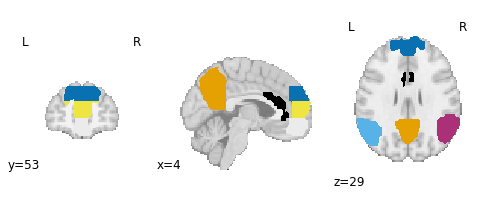

In [25]:
roi_colors = ['#0971B2', '#58B3E9', '#EFE542', '#E5A000', '#D45F00', '#AA3177', '#EEEEEE', '#000000']
roi_cmap=colors.LinearSegmentedColormap.from_list('roi', roi_colors)

plotting.plot_prob_atlas(atlas_img_resampled, draw_cross=False, cut_coords=[4, 53, 29],
                         view_type='filled_contours', cmap=roi_cmap, alpha=1)

plt.savefig('plots/hypothesis_spaces.png')

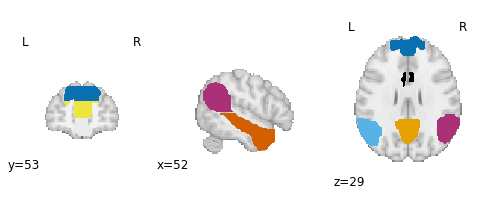

In [26]:
plotting.plot_prob_atlas(atlas_img_resampled, draw_cross=False, cut_coords=[52, 53, 29],
                         view_type='filled_contours', cmap=roi_cmap, alpha=1)

plt.savefig('plots/hypothesis_spaces_view2.png')

## Get average peak voxel locations

Retrieve peak voxel locations for each participant/ROI

In [16]:
peak_list = []

for sub, sub_df in roi_df.groupby('subject'):
    con_file = opj(con_dir, sub, 'func', 'task-tomloc_model-localizer', 'spmT_0001.nii')
    con_image = image.load_img(con_file)
    
    for _, row in sub_df.iterrows():
        # load ROI
        roi = row.roi
        roi_file = row.path
        roi_image = image.load_img(roi_file)
        
        # mask contrast using ROI
        masked_con = image.math_img("img * mask", img = con_image, mask = roi_image)
        masked_data = masked_con.get_fdata()
        
        # find location of peak voxel
        peak_val = masked_data.max()
        peak_loc = np.argwhere(masked_data == peak_val)[0].tolist()
        peak_mni = image.coord_transform(*peak_loc, con_image.affine) # convert to mni
        
        # add to list
        peak_list.append((sub, roi, *peak_mni))
        
peak_df = pd.DataFrame(peak_list, columns = ['subject', 'ROI', 'x', 'y', 'z'])
peak_df

,subject,ROI,x,y,z
0,sub-01,DMPFC,-6.293999,53.018002,37.100003
1,sub-01,LTPJ,-47.141999,-59.313999,25.200003
2,sub-01,MMPFC,5.620001,59.826002,13.300003
3,sub-01,PC,5.620001,-67.823999,32.000003
4,sub-01,RSTS,56.680002,-11.657998,-13.899998
...,...,...,...,...,...
189,sub-30,MMPFC,2.216001,49.614002,20.100003
190,sub-30,PC,-4.591999,-57.611999,37.100003
191,sub-30,RSTS,54.978002,-37.187999,1.400002
192,sub-30,RTPJ,54.978002,-55.909999,26.900003


Get average peak voxel locations:

In [17]:
avg_peak = (((peak_df.groupby(['ROI'])[['x', 'y', 'z']].agg('mean')/2).round())*2).astype(int).reset_index()

avg_peak

,ROI,x,y,z
0,DMPFC,4,54,32
1,LTPJ,-54,-60,24
2,MMPFC,4,60,14
3,PC,2,-56,40
4,RSTS,56,-8,-16
5,RTPJ,54,-58,22
6,VMPFC,0,60,-12


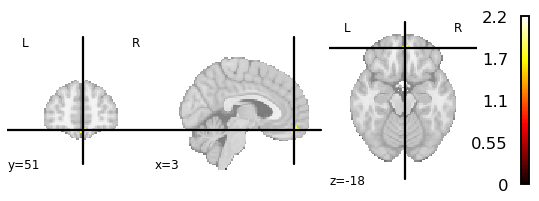

In [18]:
masked_con = image.math_img("img * mask", img = con_image, mask = roi_image)
masked_data = masked_con.get_fdata()
peak_val = masked_data.max()
peak_loc = np.argwhere(masked_data == peak_val)[0].tolist()
peak_mni = image.coord_transform(*peak_loc, con_image.affine) # convert to mni

plotting.plot_stat_map(masked_con)

## Demo: Plot all ROIs for a representative participant

Define color palette:

Load ACCg:

(114, 135, 114)


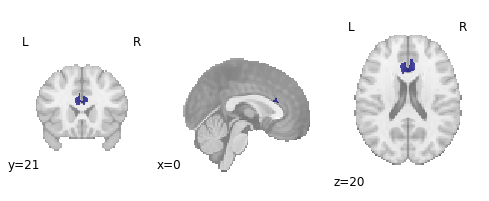

In [19]:
acc_file = '/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/fmriprep_space/bilateral_ACCg.nii.gz'
acc_image = image.load_img(acc_file)
acc_data = acc_image.get_fdata()

print(acc_data.shape)
plotting.plot_roi(acc_image, draw_cross=False)

Select participant's data:

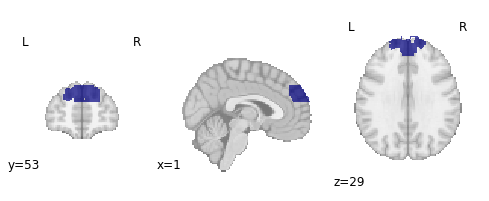

In [20]:
# get all participant ROIs
sub = 'sub-02'
sub_roi = roi_df[roi_df.subject == sub]

# load all images
sub_images = [image.load_img(f) for f in sub_roi.path]
sub_data = [img.get_fdata() for img in sub_images]
plotting.plot_roi(sub_images[0], draw_cross=False) # example roi

Putting everything together:

In [21]:
# put together all images
all_roi_data = np.array([acc_data] + sub_data)
print(all_roi_data.shape)

# aggregate
atlas_data = np.zeros(all_roi_data.shape[1:])
for idx in range(all_roi_data.shape[0]):
    roi = all_roi_data[idx,:,:]
    roi_val = idx+1
    
    atlas_data[roi > 0] = roi_val
    
atlas_img = image.new_img_like(acc_image, atlas_data)

(8, 114, 135, 114)


Plot atlas

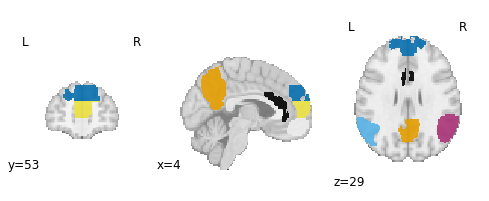

In [28]:
roi_colors = ['#000000', '#0971B2', '#58B3E9', '#EFE542', '#E5A000', '#D45F00', '#AA3177', '#EEEEEE']
roi_cmap=colors.LinearSegmentedColormap.from_list('roi', roi_colors)

plotting.plot_roi(atlas_img, draw_cross=False, cut_coords=[4, 53, 29], cmap=roi_cmap, alpha=0.9)
plt.savefig('plots/sample_roi_slice1.png')

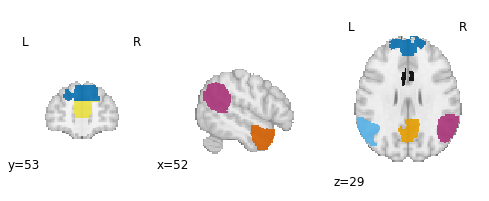

In [29]:
plotting.plot_roi(atlas_img, draw_cross=False, cut_coords=[52, 53, 29], cmap=roi_cmap, alpha=.9)
plt.savefig('plots/sample_roi_slice2.png')